<img src="../logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº5
#### Federico Borello

Hago uso de un módulo llamado `pds_utils` ubicado en el directorio base del repositorio

## Estimación Espectral

La estimación espectral es una técnica fundamental en el análisis de señales, ya que permite obtener información sobre la distribución de energía de una señal en el dominio de la frecuencia. Esta herramienta es esencial para comprender cómo se comportan las señales en diferentes rangos de frecuencia y para identificar componentes frecuenciales significativos.

En este contexto, se proponen dos estimadores: 

1. **Estimador de Magnitud**: Este estimador se obtiene al evaluar la Transformada Rápida de Fourier (FFT) de la señal en $N/4$.

2. **Estimador de Frecuencia**: Este estimador utiliza todos los valores obtenidos a partir de la FFT para estimar la frecuencia real de la señal. Al integrar toda la información disponible, se busca obtener una estimación más precisa y robusta.

Para simular un entorno más realista, se introduce ruido analógico o gaussiano en las señales. Esto permite generar diferentes realizaciones de la señal, lo que a su vez requiere realizar múltiples "experimentos" o "ensayos". A partir de estos ensayos, se calculan valores estadísticos fundamentales como la media, el sesgo y la varianza.

### Implicancia del Sesgo y la Varianza

El sesgo y la varianza son dos conceptos clave que afectan la calidad de un estimador. 

- **Sesgo**: Se refiere a la diferencia entre el valor esperado del estimador y el valor verdadero del parámetro que se está estimando. Un estimador es considerado insesgado si su sesgo es cero, lo que significa que, en promedio, proporciona estimaciones correctas del parámetro. Un sesgo significativo puede llevar a conclusiones erróneas sobre el comportamiento de la señal.

$$
\text{Sesgo}(\theta) = E(T) - \theta
$$

- **Varianza**: Representa la variabilidad de las estimaciones del estimador alrededor de su valor esperado. Un estimador con alta varianza puede producir resultados muy dispersos entre diferentes ensayos, lo que dificulta confiar en su precisión. Por otro lado, un estimador con baja varianza tiende a ser más consistente, lo que es deseable en aplicaciones prácticas.

Al utilizar la media como un valor representativo después de múltiples ensayos, es crucial considerar tanto el sesgo como la varianza del estimador. Un buen balance entre ambos aspectos asegura que las estimaciones sean precisas y confiables, permitiendo así una interpretación adecuada de los resultados obtenidos en el análisis espectral.

### Caso de la Media

Si consideramos la media poblacional $\mu$ como el parámetro a estimar y utilizamos la media muestral $\bar{X}$ como nuestro estimador, el sesgo se puede calcular de la siguiente manera:

$$
\text{Sesgo}(\bar{X}) = E(\bar{X}) - \mu
$$

Esto implica, que si estamos estimando el valor de una señal que **suponemos**, o según las especificaciones del generador de señal debería ser conocido, se puede calcular el sesgo como:

$$
\text{Sesgo}(\bar{X}) = E(\bar{X}) - \text{Valor Real}
$$
 

In [1]:
# @title: SetUp
import sys
import os

sys.path.append(os.path.abspath(".."))
from pds_utils import sine, noise

import numpy as np

amplitude = 2

# Señal a cuantizar
fs = N = 1000
spectral_res = fs / N
frequency_factor = np.random.uniform(low=-1 / 2, high=1 / 2)
omega_0 = N / 4
df = fs / N
omega_1 = omega_0 + frequency_factor * df


## Estimador de Magnitud

En el contexto de la estimación espectral, el estimador de magnitud se utiliza para calcular la magnitud de los componentes espectrales de una señal en una frecuencia específica.

$$\hat{a_i} = \left| X_{i \, , \frac{N}{4}} \right|$$

In [2]:
X_3_evaluated_at_N_over_4 = []
X_10_evaluated_at_N_over_4 = []

number_of_experiments = 200

X_3_matrix = np.zeros((number_of_experiments, N), dtype=complex)
X_10_matrix = np.zeros((number_of_experiments, N), dtype=complex)

for experiment in range(0, number_of_experiments):
    frequency_factor = np.random.uniform(low=-1 / 2, high=1 / 2)
    omega_1 = omega_0 + frequency_factor * df
    f = omega_1

    t, sr = sine.wave(
        sampling_freq=fs, samples=N, amplitude=amplitude, dc_level=0, frequency=f
    )

    # SNR
    snr_10 = 10
    snr_3 = 3
    sigma_n_sq_10 = np.var(sr) / (10 ** (snr_10 / 10))
    sn_10, n = noise.normal(sr, 0, sigma_n_sq_10, N)
    sigma_n_sq_3 = np.var(sr) / (10 ** (snr_3 / 10))
    sn_3, n = noise.normal(sr, 0, sigma_n_sq_3, N)

    # FFT
    X_3 = np.fft.fft(sn_3) / N
    X_3_matrix[experiment, :] = X_3

    X_10 = np.fft.fft(sn_10) / N
    X_10_matrix[experiment, :] = X_10

# Se multiplica por 2 porque la FFT tiene el especto simétrico y se distrbuye la energía en ambas mitades
X_3_evaluated_at_N_over_4 = 2 * np.abs(X_3_matrix[:, N // 4])
X_10_evaluated_at_N_over_4 = 2 * np.abs(X_10_matrix[:, N // 4])

mean_with_snr_3 = np.mean(X_3_evaluated_at_N_over_4)
mean_with_snr_10 = np.mean(X_10_evaluated_at_N_over_4)

print(f"Media: {mean_with_snr_3}")
print(f"Media: {mean_with_snr_10}")

# Calculo el sesgo
bias_3 = mean_with_snr_3 - amplitude
print(f"Sesgo con SNR de 3: {bias_3}")

bias_10 = mean_with_snr_10 - amplitude
print(f"Sesgo con SNR de 10: {bias_10}")

# El valor corregido sería el estimador sesgado menos el sesgo
corrected_value = mean_with_snr_3 - bias_3
print(f"Valor corregido con SNR de 3: {corrected_value}")

corrected_value = mean_with_snr_10 - bias_10
print(f"Valor corregido con SNR de 10: {corrected_value}")

# Calculo la varianza
variance_3 = np.var(X_3_evaluated_at_N_over_4)
print(f"Varianza con SNR de 3: {variance_3}")

variance_10 = np.var(X_10_evaluated_at_N_over_4)
print(f"Varianza con SNR de 10: {variance_10}")

Media: 1.7491155573202741
Media: 1.7514185992556588
Sesgo con SNR de 3: -0.25088444267972587
Sesgo con SNR de 10: -0.2485814007443412
Valor corregido con SNR de 3: 2.0
Valor corregido con SNR de 10: 2.0
Varianza con SNR de 3: 0.054160094839205385
Varianza con SNR de 10: 0.05166050300443459


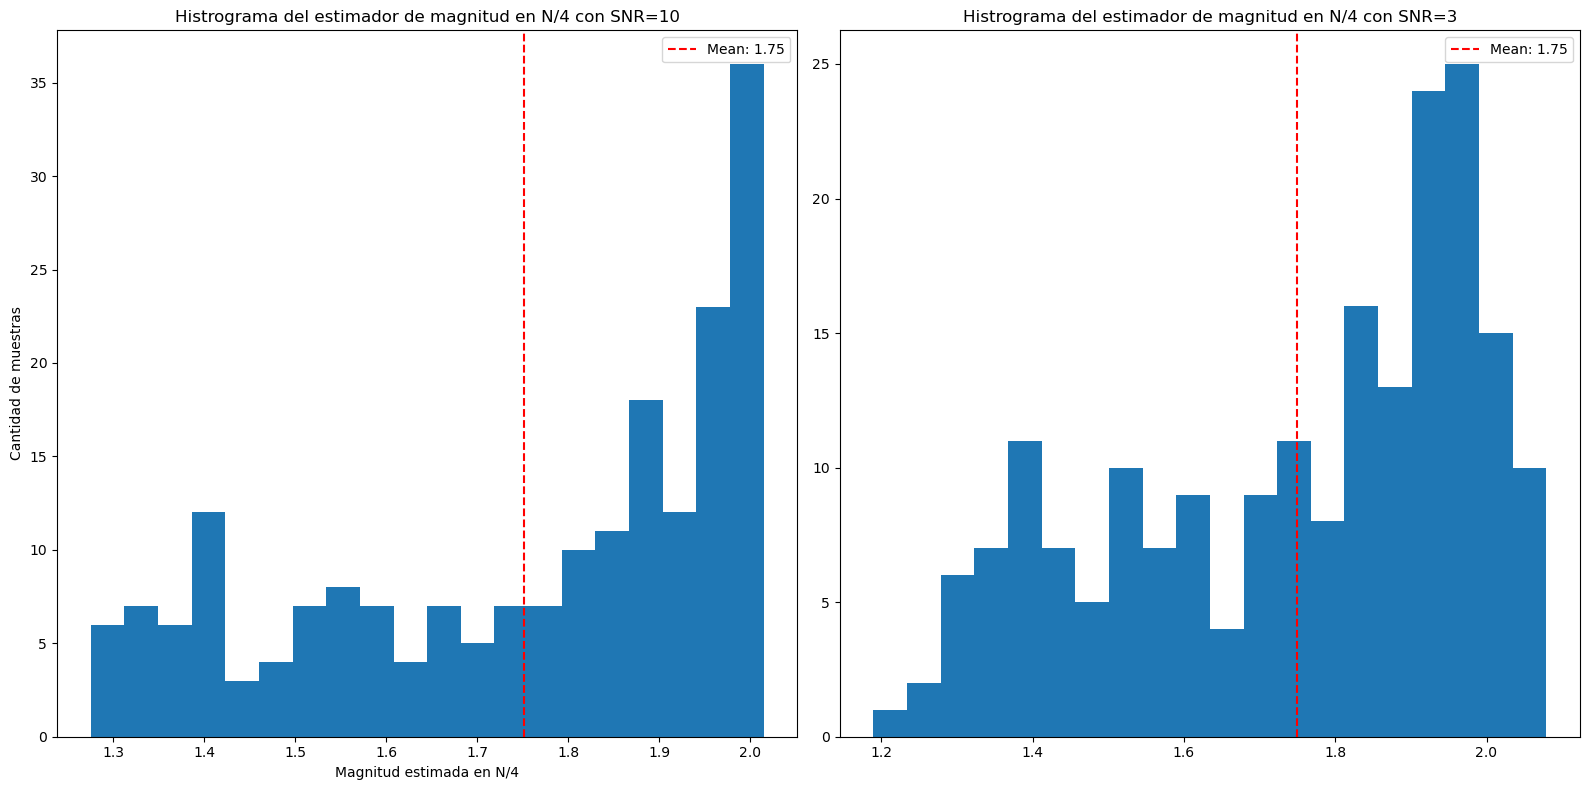

In [3]:
bins = 20
import matplotlib.pyplot as plt

fig_hist, axs_hist = plt.subplots(1, 2, figsize=(16, 8))

axs_hist[0].hist(X_10_evaluated_at_N_over_4, bins=bins)
axs_hist[0].axvline(
    mean_with_snr_10, color="r", linestyle="--", label=f"Mean: {mean_with_snr_10:.2f}"
)
axs_hist[0].legend()
axs_hist[0].set_title("Histrograma del estimador de magnitud en N/4 con SNR=10")
axs_hist[0].set_xlabel("Magnitud estimada en N/4")
axs_hist[0].set_ylabel("Cantidad de muestras")

axs_hist[1].hist(X_3_evaluated_at_N_over_4, bins=bins)
axs_hist[1].set_title("Histrograma del estimador de magnitud en N/4 con SNR=3")
axs_hist[1].axvline(
    mean_with_snr_3, color="r", linestyle="--", label=f"Mean: {mean_with_snr_10:.2f}"
)
axs_hist[1].legend()

plt.tight_layout()
plt.show()

## Conclusiones del Histograma

El Histograma muestra que la media está lejos del valor esperado, o el valor real que sería $2$. Pero intuitivamente se puede ver una mayor cantidad de muestras en torno a $2$. Si se cuenta con una referencia, de que el valor estimado es cercano a $2$ debido a la especificación del generador de señales por ejemplo, se puede decir con seguirdad que la media muestral presenta un sesgo, lo cual se soluciona con una constante como se calculó en la celda anterior.


## Estimador de Fase

$$\hat{\Omega}_1 = arg_{\Omega} \, max \left\{ \left| X_{i \, , \frac{N}{4}} \right| \right\} $$

In [4]:
arg_max_X_3_evaluated_at_N_over_4 = []
arg_max_X_10_evaluated_at_N_over_4 = []

arg_max_X_3_evaluated_at_N_over_4 = (
    np.argmax(np.abs(X_3_matrix[:, : N // 2]), axis=1) * df
)
arg_max_X_10_evaluated_at_N_over_4 = (
    np.argmax(np.abs(X_10_matrix[:, : N // 2]), axis=1) * df
)

# Media

mean_with_snr_3 = np.mean(arg_max_X_3_evaluated_at_N_over_4)
mean_with_snr_10 = np.mean(arg_max_X_10_evaluated_at_N_over_4)

print(f"Media: {mean_with_snr_3}")
print(f"Media: {mean_with_snr_10}")

# Sesgo

bias_3 = mean_with_snr_3 - omega_0
print(f"Sesgo con SNR de 3: {bias_3}")

bias_10 = mean_with_snr_10 - omega_0
print(f"Sesgo con SNR de 10: {bias_10}")

# El valor corregido sería el estimador sesgado menos el sesgo
corrected_value = mean_with_snr_3 - bias_3
print(f"Valor corregido con SNR de 3: {corrected_value}")

corrected_value = mean_with_snr_10 - bias_10
print(f"Valor corregido con SNR de 10: {corrected_value}")

# Varianza

variance_3 = np.var(arg_max_X_3_evaluated_at_N_over_4)
print(f"Varianza con SNR de 3: {variance_3}")

variance_10 = np.var(arg_max_X_10_evaluated_at_N_over_4)
print(f"Varianza con SNR de 10: {variance_10}")

Media: 249.995
Media: 250.0
Sesgo con SNR de 3: -0.0049999999999954525
Sesgo con SNR de 10: 0.0
Valor corregido con SNR de 3: 250.0
Valor corregido con SNR de 10: 250.0
Varianza con SNR de 3: 0.014975
Varianza con SNR de 10: 0.0


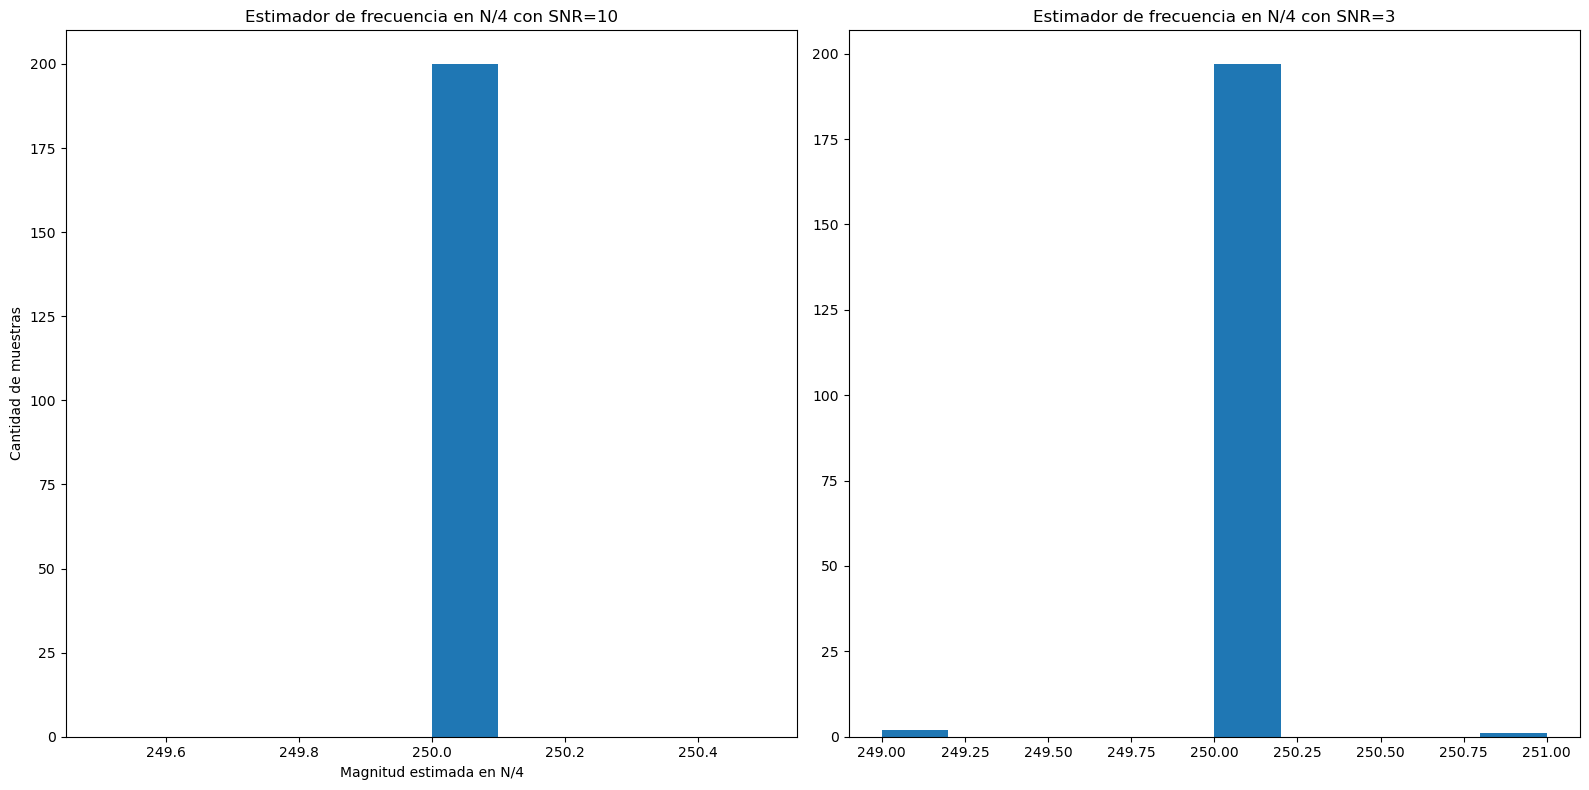

In [5]:
bins = 10
import matplotlib.pyplot as plt

fig_hist, axs_hist = plt.subplots(1, 2, figsize=(16, 8))


axs_hist[0].hist(arg_max_X_10_evaluated_at_N_over_4, bins=bins)
axs_hist[0].set_title("Estimador de frecuencia en N/4 con SNR=10")
axs_hist[0].set_xlabel("Magnitud estimada en N/4")
axs_hist[0].set_ylabel("Cantidad de muestras")

axs_hist[1].hist(arg_max_X_3_evaluated_at_N_over_4, bins=bins)
axs_hist[1].set_title("Estimador de frecuencia en N/4 con SNR=3")
plt.tight_layout()
plt.show()

## Conclusiones del Histograma

En este análisis, se observa que toda la frecuencia se concentra en la frecuencia real de la señal senoidal, con muy pocas muestras en otros valores. Esto se debe a que el `frequency_factor`, definido como `frequency_factor = np.random.uniform(low=-1 / 2, high=1 / 2)`, no tiene un rango lo suficientemente amplio para generar variaciones significativas en la frecuencia. 

La concentración de la frecuencia también está influenciada por los parámetros de la FFT, así como por el número total de muestras $N$ y la frecuencia de muestreo $f_s$. En este caso, tanto $f_s$ como $N$ están fijados en 1000. Esta configuración limita la capacidad del sistema para capturar variaciones en frecuencias diferentes a la real, lo que se refleja en el histograma.
